In [1]:
# import modules
import uproot, sys, time, random, argparse, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *

# import trackingError function
sys.path.append('/data/jlai/iris-hep-log/code/')
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

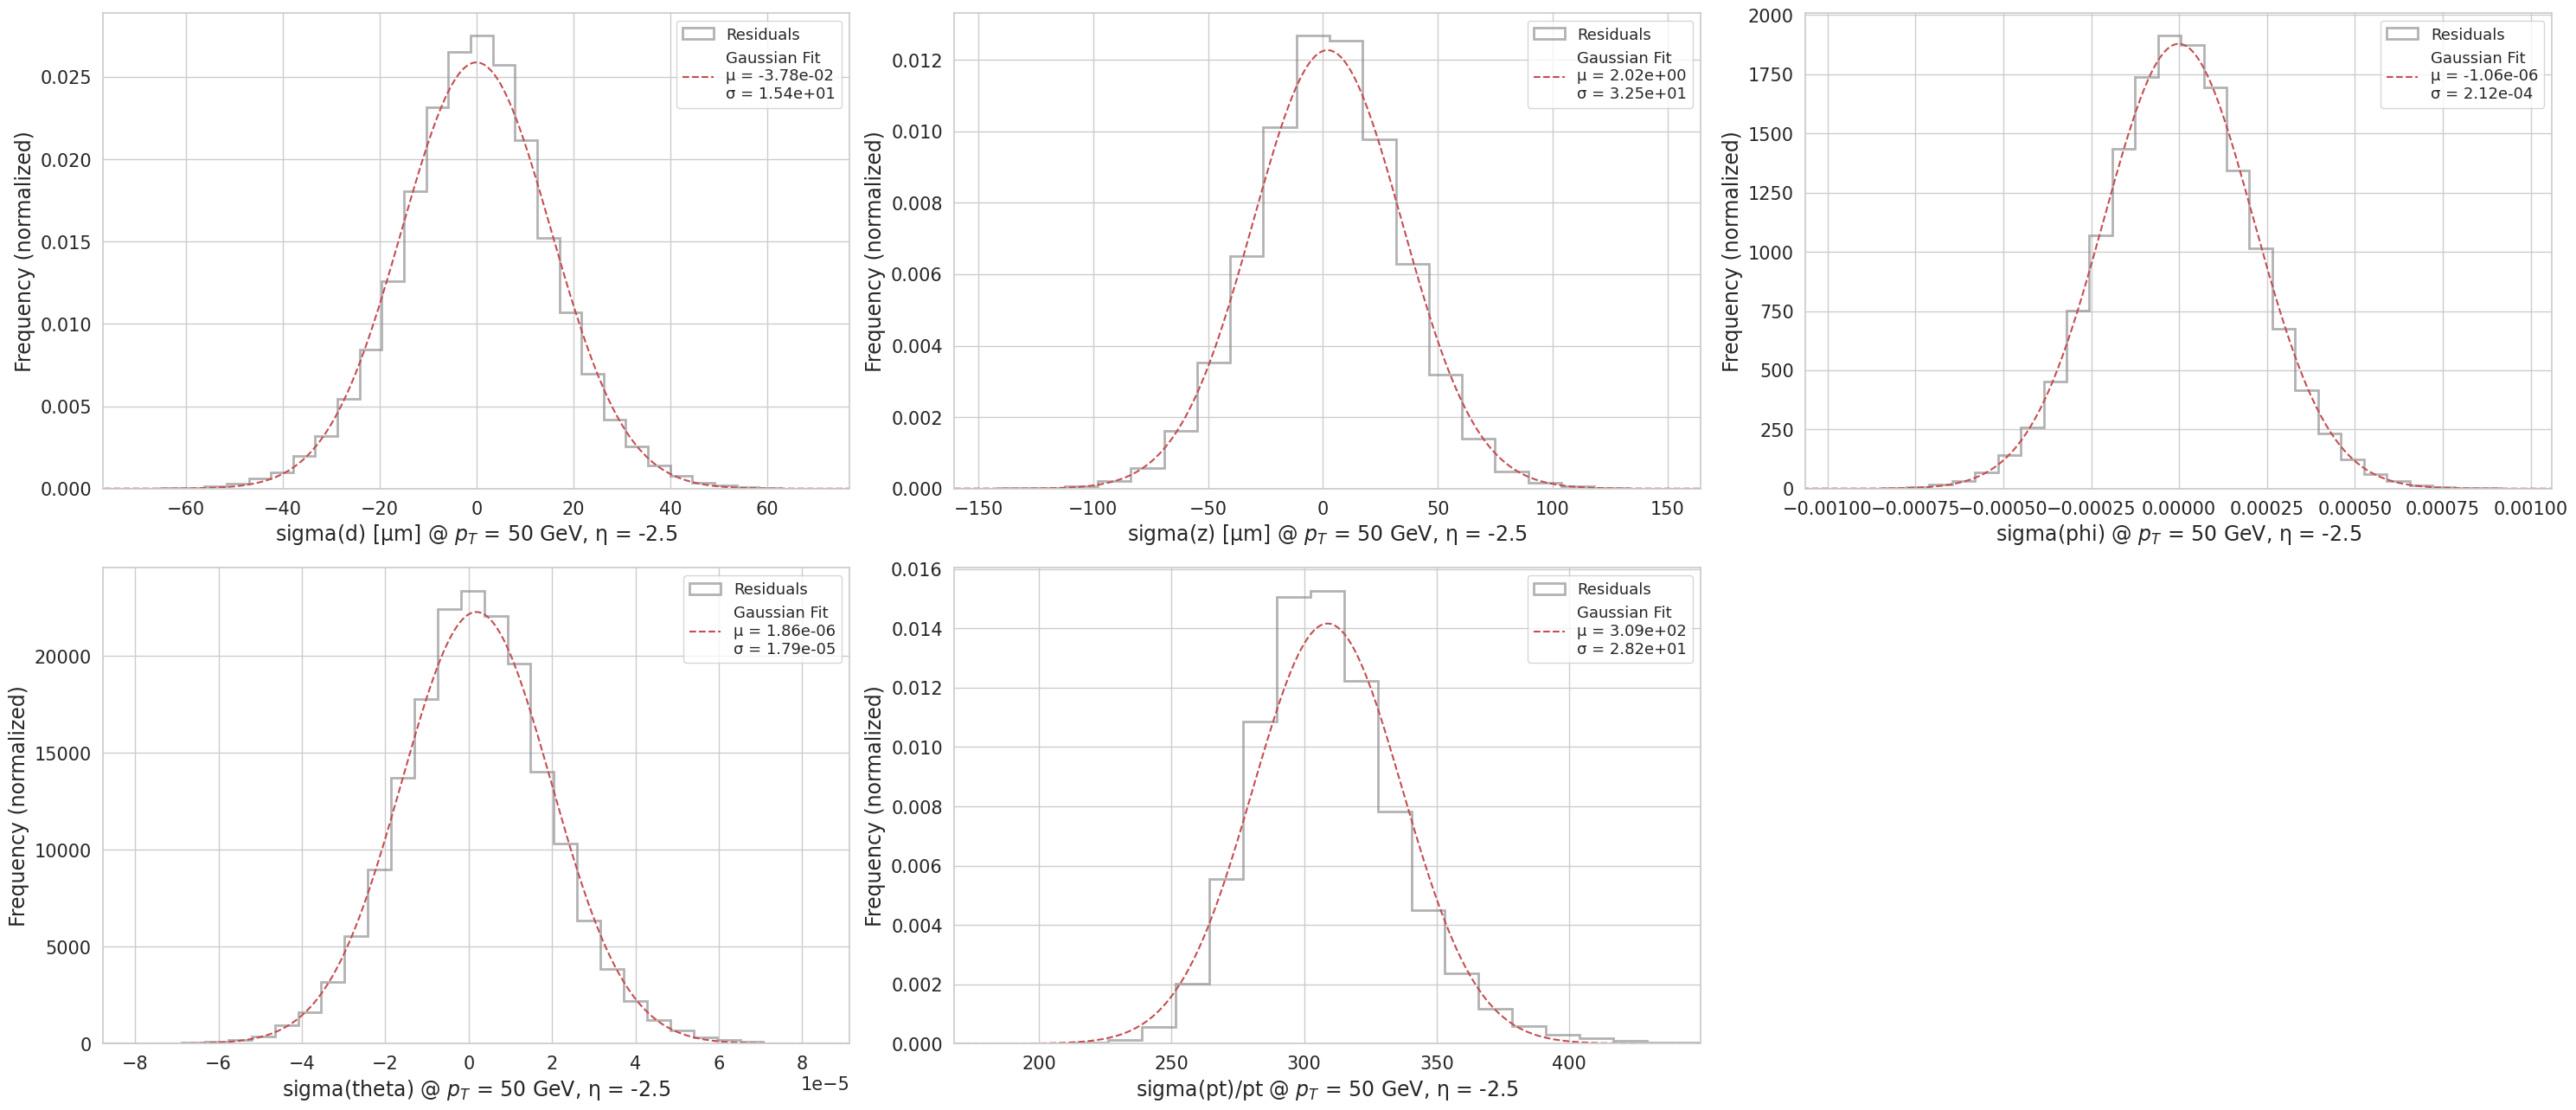

In [6]:
PT_VALUE = 50
path = f'/data/jlai/iris-hep/OutputETA_pt_{PT_VALUE}/'
eta_values = np.arange(-2.5, 2.5, 0.5)
i = 0
file = uproot.open(path + f'output_eta_{eta_values[i]}' + '/tracksummary_ckf.root')
# file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")

tree = file['tracksummary']

# < -- Fitting with no plot -- >
arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit", "pull_eLOC0_fit",
                      "t_z0", "eLOC1_fit", "res_eLOC1_fit", "pull_eLOC1_fit",
                      "t_phi", "ePHI_fit", "res_ePHI_fit", "pull_ePHI_fit",
                      "t_theta", "eTHETA_fit", "res_eTHETA_fit", "pull_eTHETA_fit",
                      "t_p", "eQOP_fit", "res_ePT_fit",
                      "t_charge"], library='ak')

pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])
p = np.abs( 1 / arrays['eQOP_fit'] )

labels = {
    'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
    'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
    'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
    'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
    # 'sigma(pt)/pt': ak.flatten(arrays['res_ePT_fit']/pT_reco),
    'sigma(pt)/pt': ak.flatten(p)
}

p, eta = PT_VALUE, eta_values[i]
B, m = 2, 0.106
fit_results = {}

# Decide the order explicitly so plots are stable
keys_order = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
title_labels = ['sigma(d) [μm]', 'sigma(z) [μm]', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

plt.figure(figsize=(30, 13))

for i, key in enumerate(keys_order):
    data = ak.to_numpy(labels[key])
    data = data[~np.isnan(data)]

    if data.size == 0:
        fit_results[key] = np.nan
        continue

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma

    plt.subplot(2, 3, i + 1)
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2,
                               density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma),
             'r--', label=f'Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.xlabel(f"{title_labels[i]} @ $p_T$ = {p} GeV, η = {eta}")
    plt.xlim(mu - 5*sigma, mu + 5*sigma)
    plt.xticks()
    # plt.xlabel(key)
    plt.ylabel("Frequency (normalized)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
# plt.savefig(f'/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots/fitted_gaussian_pT{pT_values[i]}.png')

# < -- Tracking Error Calculator -- >
# p, eta = pT_values[i], 0
# B, m = 2, 0.106
# path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
# mydetector = inputfromfile(path+'ODD.txt', 0)
# calc_result = mydetector.errorcalculation(p, B, eta, m)

# # < -- plot comparsion -- >
# var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

# plt.figure(figsize=(20, 10))
# for var_label in var_labels:
#     idx = var_labels.index(var_label)
#     plt.subplot(231 + idx)

#     key = var_label
#     y_calc = calc_result[var_label]
#     y_acts = fit_results[key]

#     plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
#     plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
#     plt.xlabel(r"$p_T$ [GeV]")
#     plt.ylabel(var_label)
#     plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
#     plt.legend()
#     plt.grid(True)

# plt.tight_layout()
plt.show()

In [10]:
PT_VALUE = 50
path = f'/data/jlai/iris-hep/OutputETA_pt_{PT_VALUE}/'
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

y_acts = {label: [] for label in var_labels}
y_acts_err = {label: [] for label in var_labels}

eta_values = np.arange(-2.5, 2.5, 0.5)
for eta_value in eta_values:
    print(f'Saving ACTS track resol with η = {eta_value}')
    file = uproot.open(path + f'output_eta_{eta_value}' + '/tracksummary_ckf.root')
    tree = file['tracksummary']

    # < -- Fitting with no plot -- >
    arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit",
                        "t_z0", "eLOC1_fit", "res_eLOC1_fit",
                        "t_phi", "ePHI_fit", "res_ePHI_fit",
                        "t_theta", "eTHETA_fit", "res_eTHETA_fit",
                        "t_p", "t_pT", "eQOP_fit", "res_eQOP_fit",
                        "t_charge"], library='ak')

    pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
    pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['t_theta'])
    # pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

    labels = {
        'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
        'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
        'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
        'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
        'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth)/pT_reco)
    }

    plt.figure(figsize=(30, 13))
    for key, data in labels.items():
        data = ak.to_numpy(data)
        data = data[~np.isnan(data)]

        N = len(data)
        mu, sigma = norm.fit(data)

        y_acts[key].append(sigma)
        # y_acts_err[key].append(sigma / np.sqrt(2 * N) if N > 0 else 0)
        y_acts_err[key].append(sigma / np.sqrt(2*max(N-1,1)) if N > 1 else 0.0)

Saving ACTS track resol with η = -2.5
Saving ACTS track resol with η = -2.0
Saving ACTS track resol with η = -1.5
Saving ACTS track resol with η = -1.0
Saving ACTS track resol with η = -0.5
Saving ACTS track resol with η = 0.0
Saving ACTS track resol with η = 0.5
Saving ACTS track resol with η = 1.0
Saving ACTS track resol with η = 1.5
Saving ACTS track resol with η = 2.0


<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

In [11]:
MAT_PATH = "/data/jlai/iris-hep/material_composition.root"

def D(pt_value, eta_value):
    def vals_edges_any(h):
        """
        Return (vals, edges) for TH1* or TProfile from uproot.
        vals: bin contents (for TProfile: mean Y per bin)
        edges: x-axis bin edges
        """
        # 1) try the easy path (TH1 with to_numpy)
        try:
            vals, edges = h.to_numpy()
            return np.asarray(vals), np.asarray(edges)
        except Exception:
            pass

        # 2) try uproot v5 axis API
        edges = None
        for getter in ("axis", "axis0", "axis", "axis(0)"):
            try:
                # some builds expose axis() or axis(0)
                ax = h.axis() if getter=="axis" else h.axis(0)
                edges = np.asarray(ax.edges())
                break
            except Exception:
                continue

        # 3) last resort: uniform fallback (only if we must)
        vals = np.asarray(h.values())
        if edges is None:
            edges = np.linspace(-5, 5, len(vals)+1)
        return vals, edges

    def x0_at_eta_interp_generic(h, eta):
        vals, edges = vals_edges_any(h)
        centers = 0.5*(edges[:-1] + edges[1:])
        eta_c = np.clip(eta, centers.min(), centers.max())
        return float(np.interp(eta_c, centers, vals))

    # ---- usage ----
    with uproot.open(MAT_PATH) as mf:
        def pick_interp(key, eta):
            v = x0_at_eta_interp_generic(mf[key], eta)
            # DEBUG: show neighbors used for interpolation
            vals, edges = vals_edges_any(mf[key])
            centers = 0.5*(edges[:-1] + edges[1:])
            i = np.searchsorted(centers, eta, side='left')
            i0 = max(i-1, 0); i1 = min(i, len(centers)-1)
            # print(f"{key}: interp at η={eta:+.3f} using "
            #     f"[η0={centers[i0]:+.3f}, val0={vals[i0]:.6g}] and "
            #     f"[η1={centers[i1]:+.3f}, val1={vals[i1]:.6g}] -> {v:.6g}")
            return v

        x0_beam  = pick_interp("beampipe_x0_vs_eta_all", eta_value)
        x0_pixel = pick_interp("pixel_x0_vs_eta_all",     eta_value)
        x0_sstr  = pick_interp("sstrips_x0_vs_eta_all",   eta_value)
        x0_lstr  = pick_interp("lstrips_x0_vs_eta_all",   eta_value)


    '''
    def x0_totals_at_eta(MAT_PATH, eta_value):
        """Return per-tech total x/X0 at this eta from the material map ROOT file (+ debug)."""
        with uproot.open(MAT_PATH) as mf:
            def pick(key, eta):
                h = mf[key]
                # Uproot TH1: prefer to_numpy(); fallback if needed
                try:
                    vals, edges = h.to_numpy()
                except Exception:
                    vals = h.values()
                    edges = np.linspace(-5, 5, len(vals) + 1)
                idx = np.searchsorted(edges, eta, side="right") - 1
                idx = int(np.clip(idx, 0, len(vals) - 1))
                lo, hi = edges[idx], edges[idx + 1]
                print(f"{key}: bin[{idx}] [{lo:+.3f},{hi:+.3f}) -> {float(vals[idx]):.6g}")
                return float(vals[idx])

            x0_beam  = pick("beampipe_x0_vs_eta_all", eta_value)
            x0_pixel = pick("pixel_x0_vs_eta_all",     eta_value)
            x0_sstr  = pick("sstrips_x0_vs_eta_all",   eta_value)
            x0_lstr  = pick("lstrips_x0_vs_eta_all",   eta_value)

        return dict(x0_beam=x0_beam, x0_pixel=x0_pixel, x0_sstr=x0_sstr, x0_lstr=x0_lstr)


    MAT_PATH = "/data/jlai/iris-hep/material_composition.root"
    totals = x0_totals_at_eta(MAT_PATH, eta_value)
    x0_beam  = totals["x0_beam"]
    x0_pixel = totals["x0_pixel"]
    x0_sstr  = totals["x0_sstr"]
    x0_lstr  = totals["x0_lstr"]

    '''


    def build_df_layers(MEAS_PATH):
        # --- Read per-hit quantities ---
        cols = ["volume_id","layer_id","true_x","true_y","true_z","var_loc0","var_loc1","residual_loc0","residual_loc1"]
        with uproot.open(MEAS_PATH) as f:
            a = f["measurements"].arrays(cols, library="pd")

        # --- Per-hit → per-layer medians + derived geometry ---
        a["R_m"]          = np.sqrt(a.true_x**2 + a.true_y**2) * 1e-3  # m
        a["Z_m"]          = np.abs(a.true_z) * 1e-3                    # m
        a["sigma_loc0_m"] = np.sqrt(a.var_loc0.clip(lower=0)) * 1e-3   # m
        a["sigma_loc1_m"] = np.sqrt(a.var_loc1.clip(lower=0)) * 1e-3   # m

        '''
        df_layers = (
            a.groupby(["volume_id","layer_id"], as_index=False)
            .agg(R_m=("R_m","median"),
                Z_m=("Z_m","median"),
                sigma_loc0_m=("sigma_loc0_m","median"),
                sigma_loc1_m=("sigma_loc1_m","median"))
            .sort_values(["volume_id","layer_id"])
            .reset_index(drop=True)
        )
        '''

        def _std_meters(s):
            return np.nanstd(s) * 1e-3

        df_layers = (
            a.groupby(["volume_id","layer_id"], as_index=False)
            .agg(R_m=("R_m","median"),
                Z_m=("Z_m","median"),
                # sigma_loc0_m=("sigma_loc0_m","median"),
                # sigma_loc1_m=("sigma_loc1_m","median"))
                res_loc0_std_m=("residual_loc0", _std_meters),
                res_loc1_std_m=("residual_loc1", _std_meters))
            .sort_values(["volume_id","layer_id"])
            .reset_index(drop=True)
        )
        
        # --- Map volume of detectors ---
        PIXEL  = {16,17,18}      # ODD: 17=barrel, 16/18=endcaps
        SSTRIP = {23,24,25}
        LSTRIP = {28,29,30}

        def vol_to_tech(vid: int) -> str:
            if vid in PIXEL:  return "pixel"
            if vid in SSTRIP: return "sstrip"
            if vid in LSTRIP: return "lstrip"
            return "pixel"  # fallback

        df_layers["tech"] = df_layers["volume_id"].map(vol_to_tech)

        # --- Barrel vs Endcap tag ---
        # Pixels: use known mapping; others: geometry heuristic (|Z| >> R ⇒ endcap)
        def is_endcap_row(row):
            vid = int(row["volume_id"])
            if vid in PIXEL:
                return vid in (16, 18)             # pixel endcaps
            if vid in SSTRIP:
                return vid in (23, 25)             # sstrip endcaps
            if vid in LSTRIP:
                return vid in (28, 30)             # lstrip endcaps
            return (row["Z_m"] > 1.2 * row["R_m"]) # heuristic for strips

        df_layers["is_endcap"] = df_layers.apply(is_endcap_row, axis=1)

        df_layers["res_loc1_std_m"] = df_layers["res_loc1_std_m"].fillna(9999.0) # fill NaN with 9999

        out = df_layers.copy()
        out["res_loc1_std_m"] = out["res_loc1_std_m"].fillna(9999.0)
        # print("Layers added (x/X0, sigma_xy [m], sigma_z [m or 9999], R [m], Z [m]):")
        # print(out[["volume_id","layer_id","tech","res_loc0_std_m","res_loc1_std_m","R_m","Z_m"]]
        #     .to_string(index=False))

        return df_layers

    MEAS_PATH = f"/data/jlai/iris-hep/OutputETA_pt_{pt_value}/output_eta_{eta_value}/measurements.root"
    df_layers = build_df_layers(MEAS_PATH)


    # --- constants: single-layer thickness at η = 0 (units: x/X0) ---
    # beampipe_thickness = 0.002275
    # pixel_thickness  = 0.012278
    # sstrip_thickness = 0.018912
    # lstrip_thickness = 0.030750

    beampipe_thickness = 0.002274493574194337
    pixel_thickness = 0.04899456469422959 / 4
    sstrip_thickness = 0.0750506761420044 / 4 
    lstrip_thickness = 0.059977850117884875 / 2

    thickness_map = {
        "beampipe": beampipe_thickness,
        "pixel":  pixel_thickness,
        "sstrip": sstrip_thickness,
        "lstrip": lstrip_thickness,
    }

    # --- angles for this eta ---
    theta = 2*np.arctan(np.exp(-eta_value))
    sinth = max(np.sin(theta), 1e-12)
    costh = max(abs(np.cos(theta)), 1e-12)
    tanth = sinth / costh

    # --- per-layer value to SAVE to Detector (no core code changes) ---
    # barrel: keep single-layer thickness
    # endcap: multiply by tan(theta) so later "/ sinθ" -> effective "/ cosθ"
    df_layers["x_over_X0_for_detector"] = df_layers.apply(
        lambda r: thickness_map[r["tech"]] * (tanth if r["is_endcap"] else 1.0),
        axis=1,
    )

    # --- predicted totals for this eta (to COMPARE with material map) ---
    # barrel layers contribute thickness/sinθ; endcap layers contribute thickness/cosθ
    df_layers["contrib_for_total"] = df_layers.apply(
        lambda r: thickness_map[r["tech"]] / (costh if r["is_endcap"] else sinth),
        axis=1,
    )

    pred_by_tech = df_layers.groupby("tech")["contrib_for_total"].sum().to_dict()

    pred_beam = beampipe_thickness / sinth
    pred_by_tech["beampipe"] = pred_beam

    map_by_tech  = {"beampipe": x0_beam, "pixel": x0_pixel, "sstrip": x0_sstr, "lstrip": x0_lstr}


    # per-tech relative differences
    rel_diff_by_tech = {
        k: (pred_by_tech.get(k, 0.0) - map_by_tech.get(k, 0.0)) / max(map_by_tech.get(k, 0.0), 1e-12)
        for k in map_by_tech.keys()
    }

    # overall totals (optionally include beampipe if you want)
    pred_total = sum(pred_by_tech.values())  # + (x0_beam if you include beampipe in map_total)
    map_total  = sum(map_by_tech.values())   # + (x0_beam if included above)
    rel_diff_total = (pred_total - map_total) / max(map_total, 1e-12)

    print(f"eta = {eta_value:+.2f}, sinθ={sinth:.4f}, cosθ={costh:.4f}")
    print("Predicted totals (sum thickness/sin or /cos):", pred_by_tech)
    print("Map totals at this eta:                    ", map_by_tech)
    print("Relative diffs per tech:                   ", {k: f"{v:+.2%}" for k,v in rel_diff_by_tech.items()})
    print(f"Overall relative diff: {rel_diff_total:+.2%}")
    display(df_layers)

    # build detector
    mydetector = Detector()

    mydetector.addlayer(beampipe_thickness, 9999.0, 9999.0, 0.024)
    # print("Added beampipe: ", beampipe_thickness, 9999.0, 9999.0, 0.024)
    for _, row in df_layers.iterrows():
        if row['is_endcap']: # endcap
            mydetector.addlayer(
                row["x_over_X0_for_detector"],
                row["res_loc0_std_m"],
                row["res_loc1_std_m"],
                row["Z_m"] * tanth,
            )
            # print("Added ", row['tech'], "(endcap) :", row["x_over_X0_for_detector"], row["res_loc0_std_m"], row["res_loc1_std_m"]/sinth, row["Z_m"] * tanth)
        else:              # barrel
            mydetector.addlayer(
                row["x_over_X0_for_detector"],
                row["res_loc0_std_m"],
                row["res_loc1_std_m"],
                row["R_m"],
            )
            # print("Added ", row['tech'], "(barrel) :", row["x_over_X0_for_detector"], row["res_loc0_std_m"], row["res_loc1_std_m"], row["R_m"])
    return mydetector

# < -- Tracking Error Calculator -- >
def cal_tmp(inputfile='ODD.txt'):
    y_calc = {label: [] for label in var_labels}

    for eta_value in eta_values:
        p, eta = PT_VALUE * np.cosh(eta_value), eta_value
        # p, eta = PT_VALUE, eta_value
        B, m = 2.0, 0.105658
        mydetector = inputfromfile(inputfile, 0)
        mydetector.addlayer(0.01225, 0.015e-3, 0.015e-3, 0.185)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

def cal(inputfile='ODD.txt'):
    y_calc = {label: [] for label in var_labels}

    for eta_value in eta_values:
        p, eta = PT_VALUE * np.cosh(eta_value), eta_value
        # p, eta = PT_VALUE, eta_value
        B, m = 2.0, 0.105658
        mydetector = inputfromfile(inputfile, 0)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

def cal2():
    y_calc = {label: [] for label in var_labels}

    for eta_value in eta_values:
        # p, eta = PT_VALUE * np.cosh(eta_value), eta_value
        p, eta = PT_VALUE, eta_value
        B, m = 2.0, 0.105658
        mydetector = D(PT_VALUE, eta)
        print("eta_value:", eta)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
y_calc_default = cal(path + "ODD.txt")
# y_calc_tmp = cal_tmp(path + "ODD.txt")
y_calc_result = cal2()


eta = -2.50, sinθ=0.1631, cosθ=0.9866
Predicted totals (sum thickness/sin or /cos): {'pixel': 0.28741075164205687, 'sstrip': 0.11410336787530309, 'beampipe': np.float64(0.013947853016594576)}
Map totals at this eta:                     {'beampipe': 0.013934677589404717, 'pixel': 0.332876409790712, 'sstrip': 0.14581154323667922, 'lstrip': 0.0}
Relative diffs per tech:                    {'beampipe': '+0.09%', 'pixel': '-13.66%', 'sstrip': '-21.75%', 'lstrip': '+0.00%'}
Overall relative diff: -15.66%


,volume_id,layer_id,R_m,Z_m,res_loc0_std_m,res_loc1_std_m,tech,is_endcap,x_over_X0_for_detector,contrib_for_total
0,16,8,0.170007,1.122600,0.000015,0.000011,pixel,True,0.002025,0.012415
1,16,10,0.161036,0.982600,0.000015,0.000011,pixel,True,0.002025,0.012415
2,16,12,0.139208,0.843800,0.000015,0.000016,pixel,True,0.002025,0.012415
3,16,14,0.118108,0.722600,0.000015,0.000015,pixel,True,0.002025,0.012415
4,16,16,0.104668,0.616800,0.000015,0.000015,pixel,True,0.002025,0.012415
5,17,2,0.032213,0.197296,0.000015,0.000015,pixel,False,0.012249,0.075112
6,17,4,0.068188,0.410792,0.000015,0.000015,pixel,False,0.012249,0.075112
7,17,6,0.114005,0.500098,0.000014,0.000015,pixel,False,0.012249,0.075112
8,23,2,0.488348,2.952500,0.000042,0.001179,sstrip,True,0.003101,0.019017
9,23,4,0.422204,2.552500,0.000042,0.001184,sstrip,True,0.003101,0.019017


eta_value: -2.5
eta = -2.00, sinθ=0.2658, cosθ=0.9640
Predicted totals (sum thickness/sin or /cos): {'lstrip': 0.062215906844872486, 'pixel': 0.22244422757387075, 'sstrip': 0.23849162915050226, 'beampipe': np.float64(0.008557089924231345)}
Map totals at this eta:                     {'beampipe': 0.008556650586031153, 'pixel': 0.21403140777891339, 'sstrip': 0.2812396574878332, 'lstrip': 0.03853953580273257}
Relative diffs per tech:                    {'beampipe': '+0.01%', 'pixel': '+3.93%', 'sstrip': '-15.20%', 'lstrip': '+61.43%'}
Overall relative diff: -1.97%


/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,volume_id,layer_id,R_m,Z_m,res_loc0_std_m,res_loc1_std_m,tech,is_endcap,x_over_X0_for_detector,contrib_for_total
0,16,12,0.171842,0.843800,0.000009,0.000005,pixel,True,0.003377,0.012706
1,16,14,0.168539,0.722600,0.000015,0.000012,pixel,True,0.003377,0.012706
2,16,16,0.162367,0.622600,0.000015,0.000009,pixel,True,0.003377,0.012706
3,17,2,0.032213,0.118424,0.000015,0.000014,pixel,False,0.012249,0.046082
4,17,4,0.068193,0.248390,0.000015,0.000015,pixel,False,0.012249,0.046082
5,17,6,0.114202,0.411666,0.000015,0.000015,pixel,False,0.012249,0.046082
6,17,8,0.170119,0.491845,0.000015,0.000015,pixel,False,0.012249,0.046082
7,23,4,0.690858,2.542500,0.000043,0.001169,sstrip,True,0.005173,0.019463
8,23,6,0.605198,2.197500,0.000042,0.001182,sstrip,True,0.005173,0.019463
9,23,8,0.511402,1.852500,0.000042,0.001190,sstrip,True,0.005173,0.019463


eta_value: -2.0
eta = -1.50, sinθ=0.4251, cosθ=0.9051
Predicted totals (sum thickness/sin or /cos): {'lstrip': 0.09939451886975154, 'pixel': 0.11525528508136296, 'sstrip': 0.17387011965982074, 'beampipe': np.float64(0.005350540553743736)}
Map totals at this eta:                     {'beampipe': 0.005327816436545027, 'pixel': 0.1415159240021115, 'sstrip': 0.18076301644765588, 'lstrip': 0.19600252041906913}
Relative diffs per tech:                    {'beampipe': '+0.43%', 'pixel': '-18.56%', 'sstrip': '-3.81%', 'lstrip': '-49.29%'}
Overall relative diff: -24.78%


/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,volume_id,layer_id,R_m,Z_m,res_loc0_std_m,res_loc1_std_m,tech,is_endcap,x_over_X0_for_detector,contrib_for_total
0,17,2,0.032213,0.070300,0.000015,0.000015,pixel,False,0.012249,0.028814
1,17,4,0.068193,0.146221,0.000015,0.000015,pixel,False,0.012249,0.028814
2,17,6,0.114206,0.243904,0.000015,0.000015,pixel,False,0.012249,0.028814
3,17,8,0.170204,0.362939,0.000015,0.000015,pixel,False,0.012249,0.028814
4,23,10,0.689941,1.542500,0.000042,0.001166,sstrip,True,0.008812,0.020729
5,23,12,0.608293,1.297500,0.000043,0.001186,sstrip,True,0.008812,0.020729
6,24,2,0.259955,0.554575,0.000042,0.001176,sstrip,False,0.018763,0.044137
7,24,4,0.359973,0.767578,0.000042,0.001177,sstrip,False,0.018763,0.044137
8,24,6,0.499948,1.059234,0.000042,0.001178,sstrip,False,0.018763,0.044137
9,28,6,1.048920,2.259500,0.000071,9999.000000,lstrip,True,0.014084,0.033132


eta_value: -1.5
eta = -1.00, sinθ=0.6481, cosθ=0.7616
Predicted totals (sum thickness/sin or /cos): {'lstrip': 0.1319271758113459, 'pixel': 0.07560256399086833, 'sstrip': 0.11580924498451743, 'beampipe': np.float64(0.0035097269883509904)}
Map totals at this eta:                     {'beampipe': 0.0035128546639212536, 'pixel': 0.08870878981692452, 'sstrip': 0.13149515522377828, 'lstrip': 0.19629705672285377}
Relative diffs per tech:                    {'beampipe': '-0.09%', 'pixel': '-14.77%', 'sstrip': '-11.93%', 'lstrip': '-32.79%'}
Overall relative diff: -22.18%


/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,volume_id,layer_id,R_m,Z_m,res_loc0_std_m,res_loc1_std_m,tech,is_endcap,x_over_X0_for_detector,contrib_for_total
0,17,2,0.032213,0.047049,0.000015,0.000015,pixel,False,0.012249,0.018901
1,17,4,0.068193,0.081165,0.000015,0.000015,pixel,False,0.012249,0.018901
2,17,6,0.114206,0.134665,0.000015,0.000015,pixel,False,0.012249,0.018901
3,17,8,0.170204,0.200473,0.000015,0.000015,pixel,False,0.012249,0.018901
4,24,2,0.259955,0.306328,0.000043,0.001182,sstrip,False,0.018763,0.028952
5,24,4,0.359973,0.423946,0.000042,0.001176,sstrip,False,0.018763,0.028952
6,24,6,0.499990,0.587986,0.000042,0.001176,sstrip,False,0.018763,0.028952
7,24,8,0.659993,0.776259,0.000042,0.001177,sstrip,False,0.018763,0.028952
8,28,12,1.049657,1.309500,0.000071,9999.000000,lstrip,True,0.025518,0.039377
9,29,2,0.820244,0.964619,0.000071,9999.000000,lstrip,False,0.029989,0.046275


eta_value: -1.0
eta = -0.50, sinθ=0.8868, cosθ=0.4621
Predicted totals (sum thickness/sin or /cos): {'lstrip': 0.06763258113018358, 'pixel': 0.05524754330319711, 'sstrip': 0.08462909112401922, 'beampipe': np.float64(0.0025647780119566004)}
Map totals at this eta:                     {'beampipe': 0.0025629323973980905, 'pixel': 0.06034762548966592, 'sstrip': 0.08804187726677248, 'lstrip': 0.07602572916447588}
Relative diffs per tech:                    {'beampipe': '+0.07%', 'pixel': '-8.45%', 'sstrip': '-3.88%', 'lstrip': '-11.04%'}
Overall relative diff: -7.45%


/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,volume_id,layer_id,R_m,Z_m,res_loc0_std_m,res_loc1_std_m,tech,is_endcap,x_over_X0_for_detector,contrib_for_total
0,17,2,0.032213,0.039355,0.000015,0.000015,pixel,False,0.012249,0.013812
1,17,4,0.068193,0.045575,0.000015,0.000015,pixel,False,0.012249,0.013812
2,17,6,0.114206,0.061733,0.000015,0.000015,pixel,False,0.012249,0.013812
3,17,8,0.170204,0.089436,0.000015,0.000015,pixel,False,0.012249,0.013812
4,24,2,0.259957,0.135893,0.000043,0.001181,sstrip,False,0.018763,0.021157
5,24,4,0.359974,0.188439,0.000042,0.001177,sstrip,False,0.018763,0.021157
6,24,6,0.499988,0.260860,0.000042,0.001178,sstrip,False,0.018763,0.021157
7,24,8,0.659993,0.344493,0.000042,0.001175,sstrip,False,0.018763,0.021157
8,29,2,0.820243,0.427969,0.000071,9999.000000,lstrip,False,0.029989,0.033816
9,29,4,1.020189,0.532185,0.000071,9999.000000,lstrip,False,0.029989,0.033816


eta_value: -0.5
eta = +0.00, sinθ=1.0000, cosθ=0.0000
Predicted totals (sum thickness/sin or /cos): {'lstrip': 0.059977850117884875, 'pixel': 0.04899456469422959, 'sstrip': 0.0750506761420044, 'beampipe': np.float64(0.002274493574194337)}
Map totals at this eta:                     {'beampipe': 0.002274493574194337, 'pixel': 0.04899456469422959, 'sstrip': 0.0750506761420044, 'lstrip': 0.059977850117884875}
Relative diffs per tech:                    {'beampipe': '+0.00%', 'pixel': '+0.00%', 'sstrip': '+0.00%', 'lstrip': '+0.00%'}
Overall relative diff: +0.00%


/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,volume_id,layer_id,R_m,Z_m,res_loc0_std_m,res_loc1_std_m,tech,is_endcap,x_over_X0_for_detector,contrib_for_total
0,17,2,0.032213,0.037247,0.000015,0.000015,pixel,False,0.012249,0.012249
1,17,4,0.068193,0.037350,0.000015,0.000015,pixel,False,0.012249,0.012249
2,17,6,0.114206,0.037287,0.000015,0.000015,pixel,False,0.012249,0.012249
3,17,8,0.170204,0.037255,0.000015,0.000015,pixel,False,0.012249,0.012249
4,24,2,0.259957,0.037020,0.000043,0.001182,sstrip,False,0.018763,0.018763
5,24,4,0.359976,0.037023,0.000042,0.001177,sstrip,False,0.018763,0.018763
6,24,6,0.499989,0.037043,0.000042,0.001177,sstrip,False,0.018763,0.018763
7,24,8,0.659993,0.037027,0.000042,0.001176,sstrip,False,0.018763,0.018763
8,29,2,0.820245,0.037027,0.000071,9999.000000,lstrip,False,0.029989,0.029989
9,29,4,1.020192,0.037051,0.000071,9999.000000,lstrip,False,0.029989,0.029989


eta_value: 0.0
eta = +0.50, sinθ=0.8868, cosθ=0.4621
Predicted totals (sum thickness/sin or /cos): {'lstrip': 0.06763258113018357, 'pixel': 0.0552475433031971, 'sstrip': 0.08462909112401922, 'beampipe': np.float64(0.0025647780119566)}
Map totals at this eta:                     {'beampipe': 0.0025610910269380028, 'pixel': 0.059854440630894463, 'sstrip': 0.09271746529996686, 'lstrip': 0.0823203955661335}
Relative diffs per tech:                    {'beampipe': '+0.14%', 'pixel': '-7.70%', 'sstrip': '-8.72%', 'lstrip': '-17.84%'}
Overall relative diff: -11.53%


/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,volume_id,layer_id,R_m,Z_m,res_loc0_std_m,res_loc1_std_m,tech,is_endcap,x_over_X0_for_detector,contrib_for_total
0,17,2,0.032213,0.038754,0.000015,0.000015,pixel,False,0.012249,0.013812
1,17,4,0.068193,0.045259,0.000015,0.000015,pixel,False,0.012249,0.013812
2,17,6,0.114206,0.060981,0.000015,0.000015,pixel,False,0.012249,0.013812
3,17,8,0.170204,0.088516,0.000015,0.000015,pixel,False,0.012249,0.013812
4,24,2,0.259957,0.135102,0.000043,0.001180,sstrip,False,0.018763,0.021157
5,24,4,0.359973,0.187350,0.000042,0.001176,sstrip,False,0.018763,0.021157
6,24,6,0.499989,0.260001,0.000042,0.001179,sstrip,False,0.018763,0.021157
7,24,8,0.659993,0.343345,0.000042,0.001177,sstrip,False,0.018763,0.021157
8,29,2,0.820245,0.427129,0.000071,9999.000000,lstrip,False,0.029989,0.033816
9,29,4,1.020190,0.531358,0.000071,9999.000000,lstrip,False,0.029989,0.033816


eta_value: 0.5
eta = +1.00, sinθ=0.6481, cosθ=0.7616
Predicted totals (sum thickness/sin or /cos): {'lstrip': 0.13192717581134586, 'pixel': 0.07560256399086832, 'sstrip': 0.11580924498451742, 'beampipe': np.float64(0.00350972698835099)}
Map totals at this eta:                     {'beampipe': 0.003497502590394824, 'pixel': 0.08597225656634883, 'sstrip': 0.14434744123565524, 'lstrip': 0.17126322467811406}
Relative diffs per tech:                    {'beampipe': '+0.35%', 'pixel': '-12.06%', 'sstrip': '-19.77%', 'lstrip': '-22.97%'}
Overall relative diff: -19.31%


/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,volume_id,layer_id,R_m,Z_m,res_loc0_std_m,res_loc1_std_m,tech,is_endcap,x_over_X0_for_detector,contrib_for_total
0,17,2,0.032213,0.046377,0.000015,0.000015,pixel,False,0.012249,0.018901
1,17,4,0.068193,0.080397,0.000015,0.000015,pixel,False,0.012249,0.018901
2,17,6,0.114206,0.133646,0.000015,0.000015,pixel,False,0.012249,0.018901
3,17,8,0.170204,0.199531,0.000015,0.000015,pixel,False,0.012249,0.018901
4,24,2,0.259956,0.305648,0.000043,0.001182,sstrip,False,0.018763,0.028952
5,24,4,0.359973,0.423027,0.000042,0.001176,sstrip,False,0.018763,0.028952
6,24,6,0.499989,0.587173,0.000042,0.001176,sstrip,False,0.018763,0.028952
7,24,8,0.659994,0.775185,0.000042,0.001177,sstrip,False,0.018763,0.028952
8,29,2,0.820240,0.963745,0.000071,9999.000000,lstrip,False,0.029989,0.046275
9,29,4,1.019266,1.116913,0.000071,9999.000000,lstrip,False,0.029989,0.046275


eta_value: 1.0
eta = +1.50, sinθ=0.4251, cosθ=0.9051
Predicted totals (sum thickness/sin or /cos): {'lstrip': 0.09939451886975151, 'pixel': 0.11525528508136301, 'sstrip': 0.1738701196598208, 'beampipe': np.float64(0.005350540553743738)}
Map totals at this eta:                     {'beampipe': 0.005348117393200224, 'pixel': 0.14186919040009638, 'sstrip': 0.20111875048129207, 'lstrip': 0.19079962335687797}
Relative diffs per tech:                    {'beampipe': '+0.05%', 'pixel': '-18.76%', 'sstrip': '-13.55%', 'lstrip': '-47.91%'}
Overall relative diff: -26.94%


/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,volume_id,layer_id,R_m,Z_m,res_loc0_std_m,res_loc1_std_m,tech,is_endcap,x_over_X0_for_detector,contrib_for_total
0,17,2,0.032213,0.069368,0.000015,0.000015,pixel,False,0.012249,0.028814
1,17,4,0.068193,0.145445,0.000015,0.000015,pixel,False,0.012249,0.028814
2,17,6,0.114206,0.243074,0.000015,0.000015,pixel,False,0.012249,0.028814
3,17,8,0.170204,0.361602,0.000015,0.000015,pixel,False,0.012249,0.028814
4,24,2,0.259955,0.553859,0.000043,0.001180,sstrip,False,0.018763,0.044137
5,24,4,0.359973,0.766605,0.000042,0.001176,sstrip,False,0.018763,0.044137
6,24,6,0.499950,1.058550,0.000042,0.001176,sstrip,False,0.018763,0.044137
7,25,2,0.608733,1.297500,0.000042,0.001182,sstrip,True,0.008812,0.020729
8,25,4,0.689941,1.542500,0.000042,0.001168,sstrip,True,0.008812,0.020729
9,30,4,0.760814,1.590500,0.000071,9999.000000,lstrip,True,0.014084,0.033132


eta_value: 1.5
eta = +2.00, sinθ=0.2658, cosθ=0.9640
Predicted totals (sum thickness/sin or /cos): {'lstrip': 0.062215906844872486, 'pixel': 0.2224442275738707, 'sstrip': 0.23849162915050226, 'beampipe': np.float64(0.008557089924231343)}
Map totals at this eta:                     {'beampipe': 0.008562566549597365, 'pixel': 0.21279085790346475, 'sstrip': 0.2836512525253635, 'lstrip': 0.03785316656117616}
Relative diffs per tech:                    {'beampipe': '-0.06%', 'pixel': '+4.54%', 'sstrip': '-15.92%', 'lstrip': '+64.36%'}
Overall relative diff: -2.05%


/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,volume_id,layer_id,R_m,Z_m,res_loc0_std_m,res_loc1_std_m,tech,is_endcap,x_over_X0_for_detector,contrib_for_total
0,17,2,0.032213,0.117467,0.000015,0.000015,pixel,False,0.012249,0.046082
1,17,4,0.068193,0.247650,0.000015,0.000015,pixel,False,0.012249,0.046082
2,17,6,0.114203,0.410852,0.000015,0.000015,pixel,False,0.012249,0.046082
3,17,8,0.170116,0.491687,0.000015,0.000015,pixel,False,0.012249,0.046082
4,18,2,0.162400,0.622600,0.000015,0.000015,pixel,True,0.003377,0.012706
5,18,4,0.168602,0.722600,0.000014,0.000015,pixel,True,0.003377,0.012706
6,18,6,0.169314,0.842600,0.000016,0.000015,pixel,True,0.003377,0.012706
7,24,2,0.259955,0.943974,0.000043,0.001182,sstrip,False,0.018763,0.070589
8,24,4,0.358630,1.129310,0.000042,0.001090,sstrip,False,0.018763,0.070589
9,25,2,0.357462,1.297500,0.000042,0.001187,sstrip,True,0.005173,0.019463


eta_value: 2.0


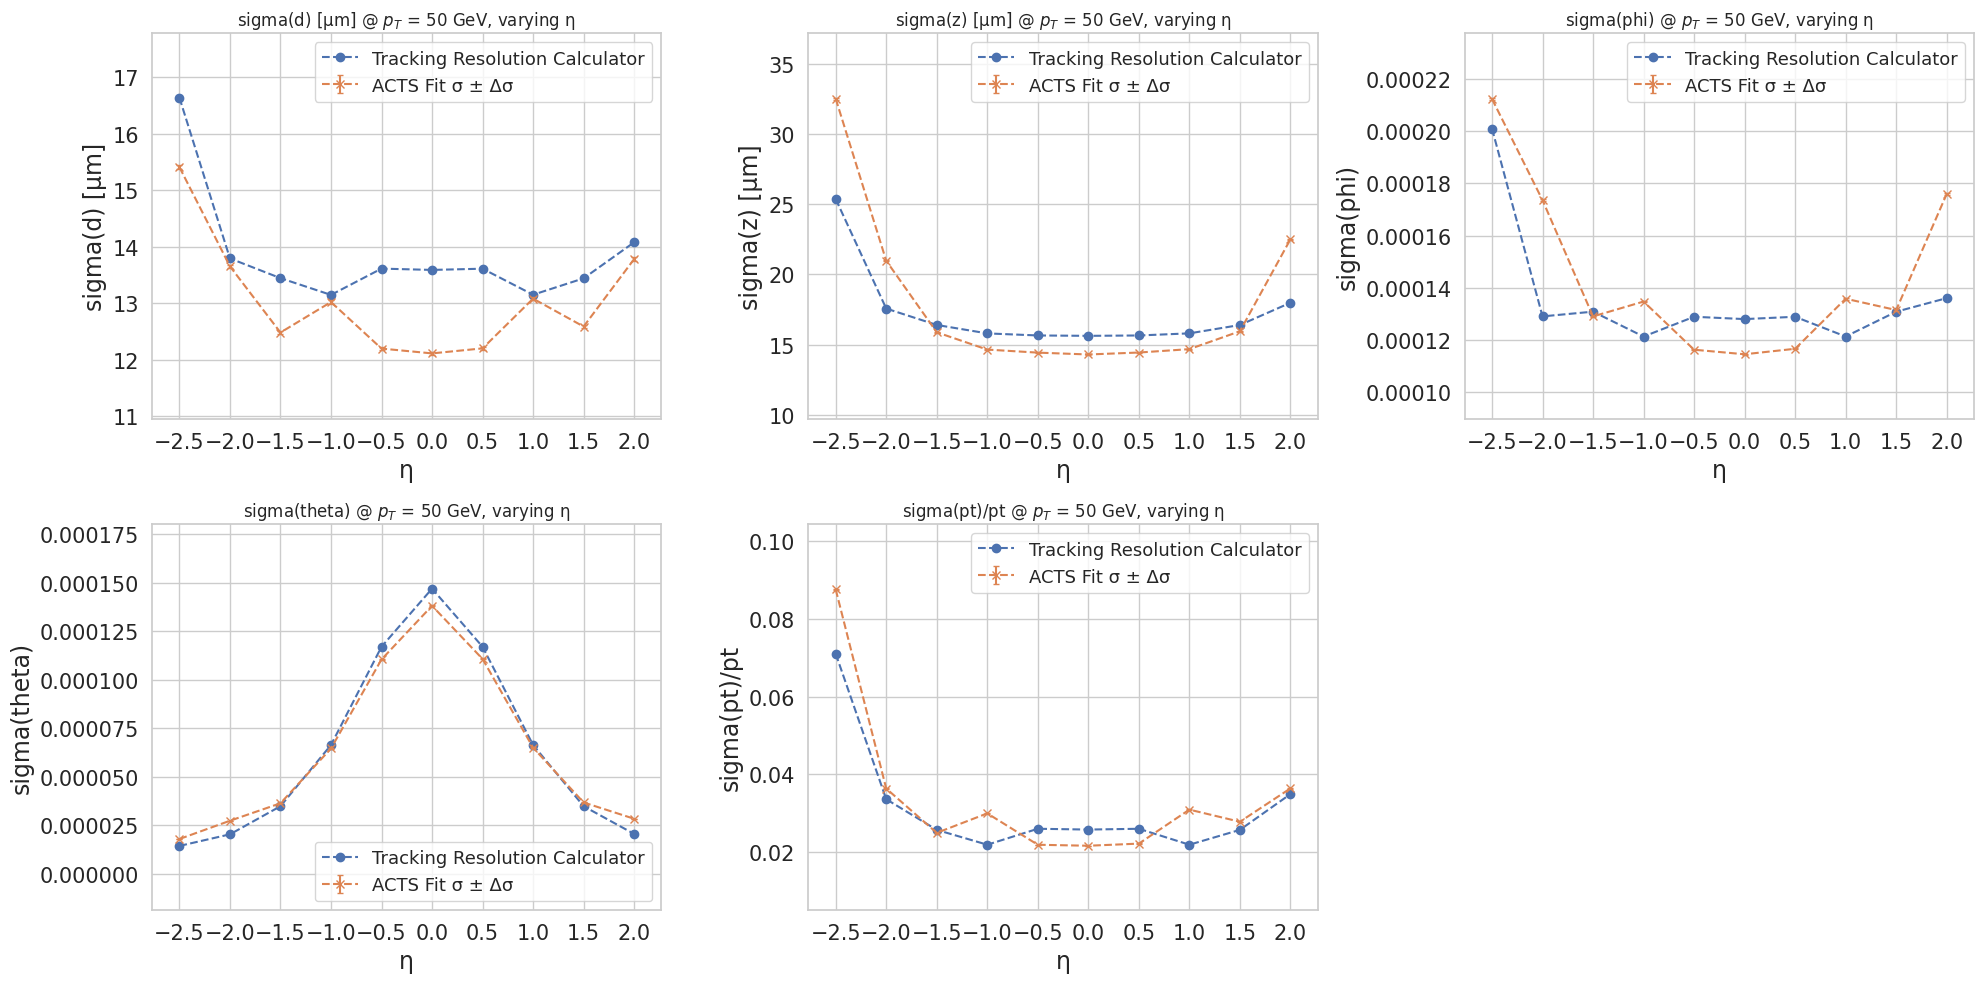

In [12]:
# < -- plot the var vs. pT -- >
title_labels = ['sigma(d) [μm]', 'sigma(z) [μm]', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

plt.figure(figsize=(20, 10))
for i in range(len(var_labels)):
    var_label = var_labels[i]
    title_label = title_labels[i]
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    # plt.plot(eta_values, y_calc_default[var_label], 'o--', label=f"Default Calculator in zenodo")
    # plt.plot(eta_values, y_calc_tmp[var_label], 'o--', label=f"tmp (add an another layer of pixel with different position)")
    plt.plot(eta_values, y_calc_result[var_label], 'o--', label=f"Tracking Resolution Calculator")

    plt.errorbar(eta_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    plt.xlabel(r"η")
    plt.xticks(eta_values)
    plt.ylabel(title_label)
    plt.title(f"{title_label} @ $p_T$ = {PT_VALUE} GeV, varying η")
    # plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.margins(x=0.06, y=0.25)  # increase y if you want even more headroom

plt.tight_layout()
plt.show()